Introducción a las Redes Neuronales para Análisis de Textos, 2024



---
# Ejercicio: Uso de Word Embeddings en un clasificador

En este notebook se explorará una colección de word embeddings preentrenada y se la utilizará para entrenar un clasificador de detección de humor.


---



Descargar una colección de embeddings.

En este ejercicio se pueden utilizar diferentes colecciones de embeddings, que darán distintos resultados. Proveemos tres alternativas, cada una con sus pros y sus contras.

1.   Embeddings del Spanish Billion Word Corpus (SBWCE): tamaño 300, están entrenados con más de mil millones de palabras en español y se cargan con gensim.
2.   Embeddings de Wikipedia en HuggingFace: tamaño 100, están entrenados con el texto de la Wikipedia en español (mucho menos texto) y se cargan con gensim.
3.   Embeddings tipo FastText de TorchNLP: tamaño 300, son otro tipo de vector distinto a word2vec, no podemos utilizar gensim por lo que hay que implementar métodos particulares para los cálculos de similitud.



In [18]:
# Alternativa 1

# Formas de bajar los embeddings de SBWC:

# Sitio oficial de la Universidad Nacional de Córdoba
# ! wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz

# Mirror en el Owncloud de Fing
! wget https://www.fing.edu.uy/owncloud/index.php/s/ryHF9xWwox3NrFe/download/SBW-vectors-300-min5.bin.gz

# Si los enlaces son demasiado lentos: bajarlo una sola vez y copiarlo a google drive
# ! cp /content/drive/MyDrive/share/SBW-vectors-300-min5.bin.gz .

# El archivo viene en un gzip, lo descomprimimos
! gzip -d SBW-vectors-300-min5.bin.gz

# Abrirlos con la biblioteca de embeddings gensim
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("./SBW-vectors-300-min5.bin", binary=True)
print(wv.vectors.shape)
embeddings_size = wv.vectors.shape[1]

--2024-10-10 17:34:05--  https://www.fing.edu.uy/owncloud/index.php/s/ryHF9xWwox3NrFe/download/SBW-vectors-300-min5.bin.gz
Resolving www.fing.edu.uy (www.fing.edu.uy)... 164.73.32.20
Connecting to www.fing.edu.uy (www.fing.edu.uy)|164.73.32.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123304474 (1.0G) [application/gzip]
Saving to: ‘SBW-vectors-300-min5.bin.gz’

SBW-vectors-300-min 100%[===================>]   1.05G  2.52MB/s    in 7m 7s   

2024-10-10 17:41:13 (2.51 MB/s) - ‘SBW-vectors-300-min5.bin.gz’ saved [1123304474/1123304474]

(1000653, 300)


Probar algunos casos simples de interés.

¿Cómo son los vectores de palabras contenidos en esta colección?

¿Qué otras palabras hay cerca de una palabra objetivo?

In [19]:
# print(wv['perro'])
print(wv.most_similar('perro'))

[('perros', 0.7533276677131653), ('cachorro', 0.753067135810852), ('gato', 0.7445881366729736), ('schnauzer', 0.7370451092720032), ('mastín', 0.7347642779350281), ('caniche', 0.7329744696617126), ('teckel', 0.7326836585998535), ('pinscher', 0.7305285930633545), ('collie', 0.7226554155349731), ('bulldog', 0.7155663967132568)]


Probar algunas analogías, utilizando el método most_similar() de gensim:

rey - hombre + mujer ≈ reina

parís - francia + uruguay ≈ montevideo

Buscar por lo menos cuatro ejemplos más de analogías.

In [20]:

# Ejempo 1: desayuno - mañana + noche ≈ cena
result = wv.most_similar(positive=['desayuno', 'noche'], negative=['mañana'], topn=1)
print("desayuno - mañana + noche ≈", result[0][0])

# Ejempo 2: invierno - frío + calor ≈ verano
result = wv.most_similar(positive=['invierno', 'calor'], negative=['frío'], topn=1)
print("invierno - frío + calor ≈", result[0][0])

# Ejempo 3: doctor - hombre + mujer ≈ doctora
result = wv.most_similar(positive=['doctor', 'mujer'], negative=['hombre'], topn=1)
print("doctor - hombre + mujer ≈", result[0][0])

# Ejemplo 4: día - sol + luna ≈ noche
result = wv.most_similar(positive=['día', 'luna'], negative=['sol'], topn=1)
print("día - sol + luna ≈", result[0][0])

desayuno - mañana + noche ≈ cena
invierno - frío + calor ≈ verano
doctor - hombre + mujer ≈ doctora
día - sol + luna ≈ noche


Probar algunas similitudes entre palabras utilizando el método similarity() de gensim

Considere los pares:

*   perro - gato
*   frío - helado
*   democracia - monarquía
*   frío - caliente

Escribir por lo menos seis pares más.

¿Cuáles deberían estar más cerca según la intuición humana?

¿Se cumple eso en los embeddings?

In [21]:
# cálculo de similitud
similarity_pairs = [
    ('sol', 'luna'),
    ('mar', 'océano'),
    ('cielo', 'nube'),
    ('amor', 'odio'),
    ('ciudad', 'pueblo'),
    ('libro', 'revista')
]

for word1, word2 in similarity_pairs:
    sim = wv.similarity(word1, word2)
    print(f"Similitud entre {word1} y {word2}: {sim:.4f}")


Similitud entre sol y luna: 0.5805
Similitud entre mar y océano: 0.7095
Similitud entre cielo y nube: 0.4407
Similitud entre amor y odio: 0.5730
Similitud entre ciudad y pueblo: 0.6191
Similitud entre libro y revista: 0.4494


R:  Los embeddings parecen capturar bien algunas relaciones intuitivas, como mar - océano y ciudad - pueblo. Pero la similitud entre amor - odio es más alta de lo esperado teniendo en cuenta que son antonimos, lo que sugiere que los embeddings están capturando una relación de contexto o intensidad emocional.

Probar el cálculo de distancia con el método distance() de gensim. ¿Cuál es la relación con el método usado en la parte anterior?

In [22]:
for word1, word2 in similarity_pairs:
    dist = wv.distance(word1, word2)
    print(f"Distancia entre {word1} y {word2}: {dist:.4f}")


Distancia entre sol y luna: 0.4195
Distancia entre mar y océano: 0.2905
Distancia entre cielo y nube: 0.5593
Distancia entre amor y odio: 0.4270
Distancia entre ciudad y pueblo: 0.3809
Distancia entre libro y revista: 0.5506


R: Como se puede observar, los pares con alta similitud tienen baja distancia y viceversa. Esto es consistente con la relación matemática entre similitud (basada en el [coseno del ángulo entre vectores](https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html)) y distancia (calculada como 1 - similitud).

Visualizar con dos técnicas de reducción de dimensionalidad: PCA y t-SNE

Probaremos con un conjunto particular de palabras de distintas clases.

Realice más pruebas utilizando otras palabras que le parezcan relevantes.

In [23]:
import matplotlib.pyplot as plt
import numpy as np

words = [
    'perro', 'gato', 'elefante', 'tiburón', 'loro', 'paloma', 'ballena',
    'democracia', 'trabajo', 'economía', 'política', 'guerra',
    'aerodinámico', 'rápido', 'lento', 'intenso', 'furioso',
    'azul', 'rojo', 'verde', 'amarillo', 'naranja',
    'lunes', 'martes', 'domingo', 'febrero', 'diciembre',
    'comer', 'saltar', 'dormir', 'volar', 'salir', 'entrar',
    'coche', 'bicicleta', 'avión', 'tren', 'barco',
    'feliz', 'triste', 'enojado', 'sorprendido', 'asustado',
    'casa', 'edificio', 'puente', 'carretera', 'parque',
    'manzana', 'banana', 'uva', 'naranja', 'fresa'
]
X = np.array([wv[w] for w in words])

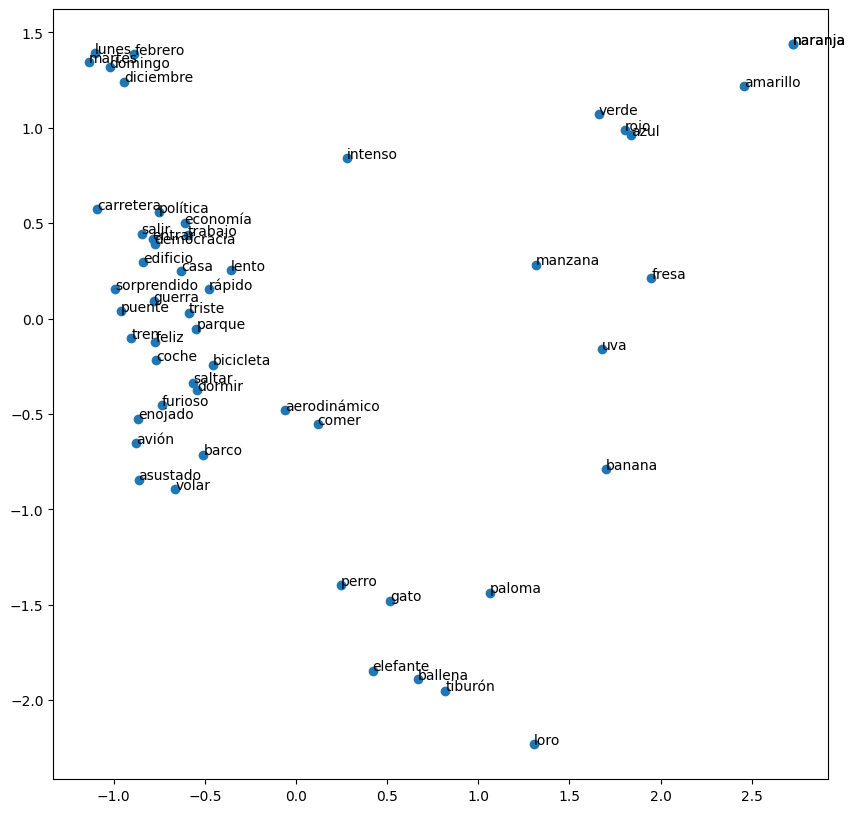

In [24]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:,0], X_pca[:,1])

for i, w in enumerate(words):
    ax.annotate(w, X_pca[i])

R: Organiza las palabras principalmente en función de la variación general en los datos, creando una visualización donde los grupos son amplios y las relaciones entre palabras no son tan precisas. Aunque palabras de temas similares (como colores o animales) están relativamente cerca, los límites entre diferentes grupos no son claros, lo que puede dificultar ver las relaciones entre temas específicos.

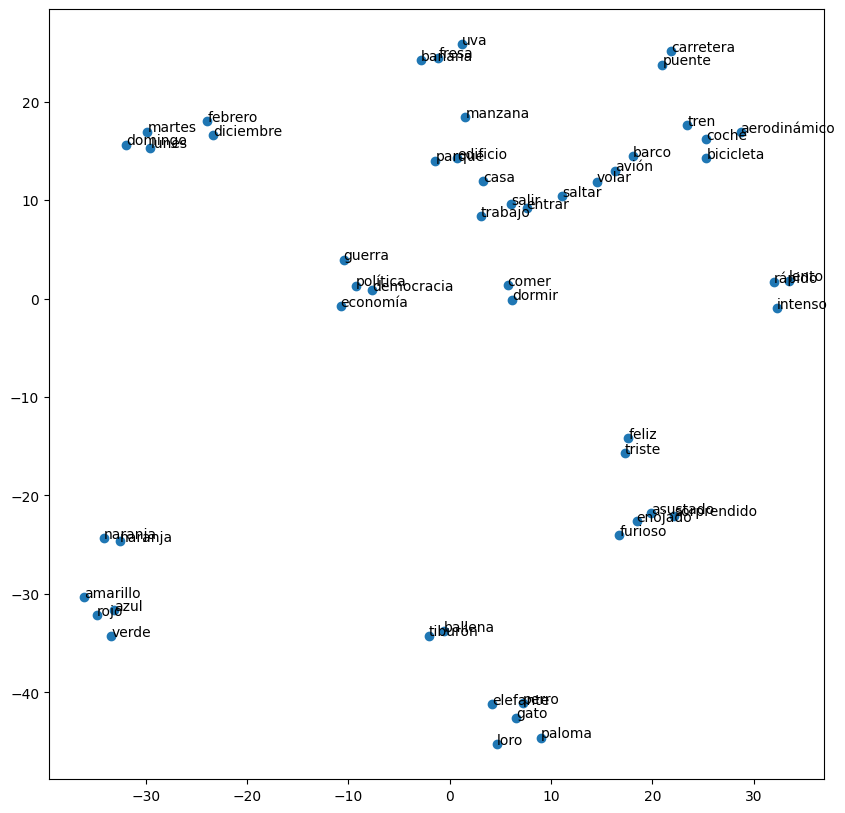

In [36]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_tsne[:,0], X_tsne[:,1])

for i, w in enumerate(words):
    ax.annotate(w, X_tsne[i])


R: Agrupa mejor las palabras similares en pequeños clústeres, mostrando claramente temas como emociones, colores o tipos de animales, lo que hace que las conexiones entre palabras sean más visibles. Y cada grupo de palabras relacionadas se ve más compacto y separado de otros, haciendo más fácil identificar cómo están organizados los temas en el espacio.

R: Conclusion: 
- PCA es útil para obtener una visión general de la distribución de palabras en el espacio, pero no es ideal para separar temas específicos o visualizar detalles finos entre palabras.

- t-SNE es excelente para mostrar grupos temáticos y relaciones cercanas entre palabras, ofreciendo una visualización más clara y detallada de cómo están relacionadas semánticamente.

Obtener y cargar el corpus de detección de humor. Este corpus tiene varias columnas, y fue utilizado en la competencia [HAHA 2021](https://www.fing.edu.uy/inco/grupos/pln/haha/). Las que nos interesarán en este ejercicio son las columnas `text` que contiene el texto del tweet, y la columna `is_humor` que indica si el tweet es un chiste o no.

In [26]:
! wget https://www.fing.edu.uy/owncloud/index.php/s/PJHnZ3rKe34mqc9/download/haha_2021.zip
! unzip haha_2021.zip

--2024-10-10 17:41:29--  https://www.fing.edu.uy/owncloud/index.php/s/PJHnZ3rKe34mqc9/download/haha_2021.zip
Resolving www.fing.edu.uy (www.fing.edu.uy)... 164.73.32.20
Connecting to www.fing.edu.uy (www.fing.edu.uy)|164.73.32.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1718382 (1.6M) [application/zip]
Saving to: ‘haha_2021.zip’

haha_2021.zip       100%[===================>]   1.64M  2.83MB/s    in 0.6s    

2024-10-10 17:41:30 (2.83 MB/s) - ‘haha_2021.zip’ saved [1718382/1718382]

Archive:  haha_2021.zip
  inflating: haha_2021_dev_gold.csv  
  inflating: haha_2021_test_gold.csv  
  inflating: haha_2021_train.csv     


In [27]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

train_df = pd.read_csv('./haha_2021_train.csv')
dev_df = pd.read_csv('./haha_2021_dev_gold.csv')
test_df = pd.read_csv('./haha_2021_test_gold.csv')
train_df.sample(5)


,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
20485,tweet20486,Mi espalda no es un correo de voz. Lo que quie...,0,3,0,0,0,0,0,NaN,NaN,NaN
14801,tweet14802,Tengo un pasado tan oscuro que me combina con ...,1,0,1,1,2,0,1,2.8000,analogy,NaN
19851,tweet19852,Voy escribir en una piedra te extraño y te la ...,1,0,4,0,0,0,1,1.8000,wordplay,NaN
13493,tweet13494,Que funcione la libertad en mi país #libertadz...,0,3,0,0,0,0,0,NaN,NaN,NaN
16602,tweet16603,Con auriculares: No me hables. Sin auriculares...,1,2,2,1,0,0,0,1.3333,reference,NaN


Para utilizar los textos del corpus en un clasificador, debemos realizar las siguientes acciones:

1.   Preprocesar los textos (p.e. tokenizar)
2.   Transformarlos a una representación vectorial (p.e. centroide)
3.   Obtener los labels del corpus (que son valores 0 o 1) como array de numpy.


In [28]:
import re

def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

train_tokens = [tokenize(t) for t in train_df.loc[:, 'text']]
dev_tokens = [tokenize(t) for t in dev_df.loc[:, 'text']]
test_tokens = [tokenize(t) for t in test_df.loc[:, 'text']]

El tokenizador implementado es una función básica que realiza las siguientes operaciones:
1. Convierte todo el texto a minúsculas para uniformidad.
2. Utiliza una expresión regular para identificar y extraer palabras.
3. Devuelve una lista de tokens (palabras individuales) del texto.
 
Este enfoque simple es efectivo para la mayoría de los casos, pero puede tener limitaciones
con ciertos tipos de texto, como aquellos que contienen emojis, hashtags o menciones de usuario.


In [29]:
def get_matrix(tokens):
    embeddings = []
    for tweet_tokens in tokens:
        tweet_embeddings = []
        for token in tweet_tokens:
            if token in wv:
                tweet_embeddings.append(wv[token])
        if tweet_embeddings:
            tweet_embedding = np.mean(tweet_embeddings, axis=0)  # promedio de los embeddings
        else:
            tweet_embedding = np.zeros(embeddings_size)
        embeddings.append(tweet_embedding)
    return np.array(embeddings)

train_v = get_matrix(train_tokens)
dev_v = get_matrix(dev_tokens)
test_v = get_matrix(test_tokens)

print(train_v.shape)
print(dev_v.shape)
print(test_v.shape)

(24000, 300)
(6000, 300)
(6000, 300)


La función get_matrix convierte los tokens de cada tweet en una representación vectorial:
1. Para cada token en un tweet, busca su embedding en el modelo de word2vec (wv).
2. Calcula el promedio de los embeddings de todos los tokens del tweet.
3. Retorna una matriz numpy donde cada fila es el embedding promedio de un tweet.

Esto nos permite obtener una representación vectorial de cada tweet en el espacio latente.

In [30]:

train_labels = np.array(train_df.loc[:,'is_humor'])
dev_labels = np.array(dev_df.loc[:,'is_humor'])
test_labels = np.array(test_df.loc[:,'is_humor'])

print("train",np.bincount(train_labels))
print("dev",np.bincount(dev_labels))
print("test",np.bincount(test_labels))


train [14747  9253]
dev [3658 2342]
test [3000 3000]


El siguiente código es un script de evaluación muy simple que toma un clasificador, un conjunto de datos y sus labels esperados, y nos devuelve Precisión, Recall, F1 y Accuracy.

Utilizaremos este script de evaluación para comparar todos nuestros resultados.


In [31]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate(clf,vectors,labels):
  pred = clf.predict(vectors)
  p,r,f,s = precision_recall_fscore_support(labels,pred)
  a = accuracy_score(labels,pred)
  print("P %s, R %s, F %s, A %s" % (p[1],r[1],f[1],a))


Entrenar clasificadores en sklearn intentando encontrar el mejor para los datos de dev. Por ejemplo: LogisticRegression, RandomForestClassifier, SVC.

In [32]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(random_state=42, max_iter=1000)
clf1.fit(train_v, train_labels)

# Evaluar en el conjunto de entrenamiento
print("Rendimiento en el conjunto de entrenamiento:")
evaluate(clf1, train_v, train_labels)

# Evaluar en dev set
print("Rendimiento en el conjunto de dev:")
evaluate(clf1, dev_v, dev_labels)

Rendimiento en el conjunto de entrenamiento:
P 0.692494292237443, R 0.5244785474981087, F 0.5968882602545968, A 0.726875
Rendimiento en el conjunto de dev:
P 0.6865833785985878, R 0.5397096498719044, F 0.6043509442983505, A 0.7241666666666666


In [33]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limitar la profundidad de los árboles
    min_samples_split=5,  # Aumentar las muestras mínimas necesarias para dividir un nodo interno
    min_samples_leaf=2,  # Aumentar las muestras mínimas requeridas para que un nodo sea una hoja
    max_features='sqrt',  # Usamos como maximo la raiz de la cantidad de feactures  
    random_state=42
)
clf2.fit(train_v, train_labels)

# Evaluar en el conjunto de entrenamiento
print("Random Forest - Rendimiento en el conjunto de entrenamiento:")
evaluate(clf2, train_v, train_labels)

# Evaluar en dev set
print("Random Forest - Rendimiento en el conjunto de dev:")
evaluate(clf2, dev_v, dev_labels)

# Comparar con el clasificador de Regresión Logística
print("\nComparacion:")
print("LogisticRegression - Rendimiento en el conjunto de entrenamiento:")
evaluate(clf1, train_v, train_labels)
print("LogisticRegression - Rendimiento en el conjunto de dev:")
evaluate(clf1, dev_v, dev_labels)


Random Forest - Rendimiento en el conjunto de entrenamiento:
P 0.8935561577838, R 0.6414135955906193, F 0.7467757156338471, A 0.8322916666666667
Random Forest - Rendimiento en el conjunto de dev:
P 0.7142857142857143, R 0.4120409906063194, F 0.5226103438938532, A 0.7061666666666667

Comparacion:
LogisticRegression - Rendimiento en el conjunto de entrenamiento:
P 0.692494292237443, R 0.5244785474981087, F 0.5968882602545968, A 0.726875
LogisticRegression - Rendimiento en el conjunto de dev:
P 0.6865833785985878, R 0.5397096498719044, F 0.6043509442983505, A 0.7241666666666666


# Análisis del Mejor Clasificador

Basándonos en los resultados obtenidos, el mejor clasificador para este problema es la Regresión Logística (LogisticRegression).

1. La Regresión Logística muestra un rendimiento consistente tanto en el conjunto de entrenamiento como en el conjunto dev, lo que sugiere una buena generalización.

2. Comparado con el Random Forest, la Regresión Logística parece tener menos sobreajuste, ya que la diferencia entre el rendimiento en entrenamiento y dev es menor.

3. La Regresión Logística es un modelo más simple que el Random Forest, lo que puede ser beneficioso en términos de eficiencia computacional.

4. Por sobre todo, la regresion logistica obtuvo mejores metrics en el conjunto de dev, lo cual sugiere que es mejor clasificador.


In [34]:
# %% [markdown]
# Evaluar sobre el conjunto de test la performance del mejor clasificador encontrado

# %%
clf_best = clf1  # Logistic Regression 
print("Rendimiento de Regresion Logistica en el conjunto de test:")
evaluate(clf_best, test_v, test_labels)

Rendimiento de Regresion Logistica en el conjunto de test:
P 0.7832263978001833, R 0.5696666666666667, F 0.659590891547665, A 0.706
